In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import torch
import torch.nn as nn
import torch.optim as optim
import os

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18,googlenet, densenet121,mobilenet_v3_small,mobilenet_v3_large
from sklearn.model_selection import train_test_split
from PIL import Image

def multiple_dir_files_to_df(dirs, label):
    df = pd.DataFrame()
    for idx,dir in enumerate(dirs):
        files = os.listdir(dir)
        files = [dir + '/' + file for file in files]
        df = pd.concat([df,pd.DataFrame({'file': files, 'label': label[idx]})])
    return df

common_path="Image/"

labels=["neutral","happy","sad","fear","angry","surprise","disgust"]
full_labels =["neutral","happy","sad","fear","angry","surprise","disgust","Happily_Surprised",
"Happily_Disgusted","Sadly_Fearful","Sadly_Angry","Sadly_Surprised","Sadly_Disgusted",
"Fearfully_Angry","Fearfully_Surprised","Fearfully_Disgusted","Angrily_Surprised",
"Angrily_Disgusted","Disgustedly_Surprised","Appalled","Hatred","Awed"]

database=[common_path+label for label in labels]
database_full=[common_path+label for label in full_labels]

def training_test_model(train_loader, val_loader, test_loader, model,model_name,epochs=50, learning_rate=0.001,weight_decay=1e-4,gamma=0.9,early_stopping_patience=5,early_stopping_save=True):
    # Initialiser le modèle et le journal
    model = model
    patience = early_stopping_patience
    best_val_loss = float('inf')
    counter = 0
    accuracy_val_list=[]
    accuracy_train_list=[]
    loss_val_list=[]
    loss_train_list=[]
    
    # Entraîner le modèle
    num_epochs = epochs
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Définir l'optimiseur et la fonction de perte
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=gamma)
    # Entraîner le modèle
    for epoch in range(num_epochs):
        accuracy_train=[]
        loss_train=[]
        accuracy_val=[]
        loss_val=[]
        accuracy_test=[]
        loss_test=[]
        current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]

        model.train()
        for batch_idx, (data, targets) in enumerate(train_loader):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data)
            loss = criterion(scores, targets.long())

            # backward
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            likelihood, predictions = scores.max(1)
            loss_train.append(loss.item())
            accuracy_train.append((predictions == targets).float().mean().item())

            # gradient descent or adam step
        scheduler.step()

        model.eval()
        for batch_idx, (data, targets) in enumerate(val_loader):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data)
            loss = criterion(scores, targets.long())
            
            likelihood, predictions = scores.max(1)
            loss_val.append(loss.item())
            accuracy_val.append((predictions == targets).float().mean().item())

        #testing the model
        for batch_idx, (data, targets) in enumerate(test_loader):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data)
            loss = criterion(scores, targets.long())
            
            likelihood, predictions = scores.max(1)
            loss_test.append(loss.item())
            accuracy_test.append((predictions == targets).float().mean().item())

        accuracy_train=np.array(accuracy_train).mean()
        loss_train=np.array(loss_train).mean()
        accuracy_val=np.array(accuracy_val).mean()
        loss_val=np.array(loss_val).mean()
        accuracy_test=np.array(accuracy_test).mean()
        loss_test=np.array(loss_test).mean()
        accuracy_val_list.append(accuracy_val)
        accuracy_train_list.append(accuracy_train)
        loss_val_list.append(loss_val)
        loss_train_list.append(loss_train)
        
        if early_stopping_save:
            if loss_val < best_val_loss:
                best_val_loss = loss_val
                best_val_accuracy = accuracy_val
                counter = 0
                best_params = model.state_dict()
            else:
                counter += 1
            if counter > patience:
                print("Early stopping at epoch: ",epoch)
                print("Saving model...")
                saved_params = model.state_dict()
                # get percentage of accuracy
                best_val_accuracy = np.round(best_val_accuracy*100,0)
                torch.save(saved_params, f"./models_tg/{model_name}_{str(int(best_val_accuracy))}.pth")
                return accuracy_val_list,accuracy_train_list,loss_val_list,loss_train_list
        print(f"Train epoch: {epoch}, accuracy = {accuracy_train} ,loss = {loss_train}, lr = {np.round(current_lr,6)}")
        print(f"val epoch: {epoch}, accuracy = {accuracy_val} ,loss = {loss_val}")
        print(f"test epoch: {epoch}, accuracy = {accuracy_test} ,loss = {loss_test}")

    
    torch.save(model.state_dict(), f"./models/{model_name}.pth")
    return accuracy_val_list,accuracy_train_list,loss_val_list,loss_train_list

def plot_train_loss(accuracy_test_list,accuracy_train_list,loss_test_list,loss_train_list,model_name):
    plt.figure(figsize=(10,5))
    plt.plot(accuracy_test_list,label="accuracy_test")
    plt.plot(accuracy_train_list,label="accuracy_train")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy for "+model_name+" model")
    plt.legend()
    plt.figure(figsize=(10,5))
    plt.plot(loss_test_list,label="loss_test")
    plt.plot(loss_train_list,label="loss_train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss for "+model_name+" model")
    plt.legend()


df = multiple_dir_files_to_df(database,np.linspace(0,6,7))
X,y=df["file"].tolist(),df["label"].tolist()

#Split the dataset into train and test
df_full = multiple_dir_files_to_df(database_full,np.linspace(0,21,22))
X_full,y_full=df_full["file"].tolist(),df_full["label"].tolist()


X_train_full,X_test_full,y_train_full,y_test_full = train_test_split(X_full,y_full,test_size=0.1, random_state=42)

#get data with labels
X_train = [X_train_full[i] for i in range(len(X_train_full)) if int(y_train_full[i]) < 7]
y_train = [y_train_full[i] for i in range(len(y_train_full)) if int(y_train_full[i]) < 7]

X_test = [X_test_full[i] for i in range(len(X_test_full)) if int(y_test_full[i]) < 7]
y_test = [y_test_full[i] for i in range(len(y_test_full)) if int(y_test_full[i]) < 7]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print("Train head: ",X_train[:5],"\n",y_train[:5])
print("Test head: ",X_test[:5],"\n",y_test[:5])

# Définir un Dataset personnalisé
class CustomDataset(Dataset):
    def __init__(self, file_names, labels, transform=None):
        self.file_names = file_names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_path = f'{self.file_names[idx]}' 
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        image, label = image.to(device), label.to(device)

        return image, label
    
# Define the image transformations
train_transform = transforms.Compose([
    transforms.CenterCrop((500, 500)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.CenterCrop((500, 500)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
# Créer les jeux de données et les chargeurs de données
train_dataset = CustomDataset(X_train, y_train, train_transform)
val_dataset = CustomDataset(X_val, y_val, train_transform)
test_dataset = CustomDataset(X_test, y_test, test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class MobileNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.mobilenet = mobilenet_v3_small(weights='IMAGENET1K_V1')
        self.mobilenet.classifier[3] = nn.Linear(1024, 7)
    def forward(self, x):
        return self.mobilenet(x)

Train head:  ['Image/angry/05_068.jpg', 'Image/disgust/07_188.jpg', 'Image/happy/02_166.jpg', 'Image/neutral/01_047.jpg', 'Image/disgust/07_016.jpg'] 
 [4.0, 6.0, 1.0, 0.0, 6.0]
Test head:  ['Image/surprise/06_106.jpg', 'Image/neutral/01_080.jpg', 'Image/neutral/01_229.jpg', 'Image/neutral/01_066.jpg', 'Image/disgust/07_147.jpg'] 
 [5.0, 0.0, 0.0, 0.0, 6.0]


In [106]:
set(y_train)

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0}

In [102]:
len(X_full)

5060

In [70]:
database

['Image/neutral',
 'Image/happy',
 'Image/sad',
 'Image/fear',
 'Image/angry',
 'Image/surprise',
 'Image/disgust']

In [ ]:
test_database = pd.DataFrame()
test_database["filename"] = X_test


In [123]:
model=MobileNet()


In [124]:
print(model)

MobileNet(
  (mobilenet): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv

Train epoch: 0, accuracy = 0.5618967188371194 ,loss = 1.1086176086116482, lr = 0.001
val epoch: 0, accuracy = 0.3875 ,loss = 3.3482977151870728
test epoch: 0, accuracy = 0.4947916666666667 ,loss = 2.3443960348765054
Train epoch: 1, accuracy = 0.8304777999182005 ,loss = 0.49563936325343877, lr = 0.0009
val epoch: 1, accuracy = 0.425 ,loss = 2.5804632544517516
test epoch: 1, accuracy = 0.6354166666666666 ,loss = 1.6150680612772703
Train epoch: 2, accuracy = 0.8648648648648649 ,loss = 0.3548913553759858, lr = 0.00081
val epoch: 2, accuracy = 0.35 ,loss = 3.729909062385559
test epoch: 2, accuracy = 0.3958333333333333 ,loss = 3.545326509823402
Train epoch: 3, accuracy = 0.9005791512695519 ,loss = 0.2641373979481491, lr = 0.000729
val epoch: 3, accuracy = 0.35 ,loss = 3.121206760406494
test epoch: 3, accuracy = 0.4166666666666667 ,loss = 2.8751763105392456
Train epoch: 4, accuracy = 0.9263996143598814 ,loss = 0.2219951028960782, lr = 0.000656
val epoch: 4, accuracy = 0.48125 ,loss = 2.566905

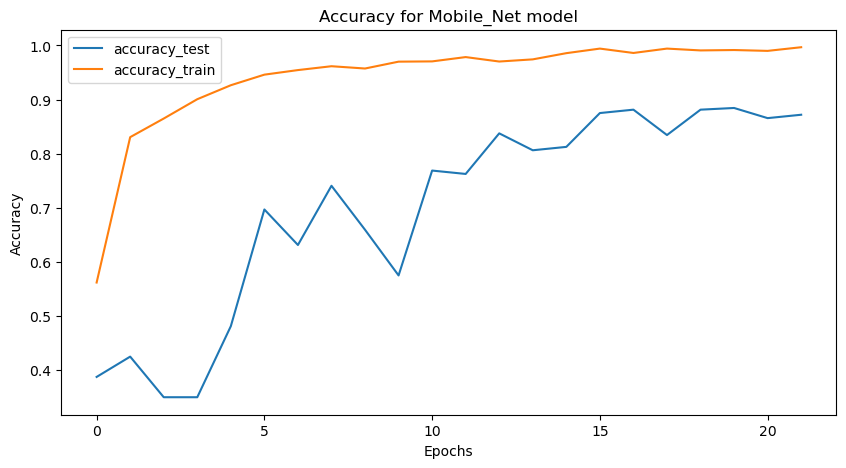

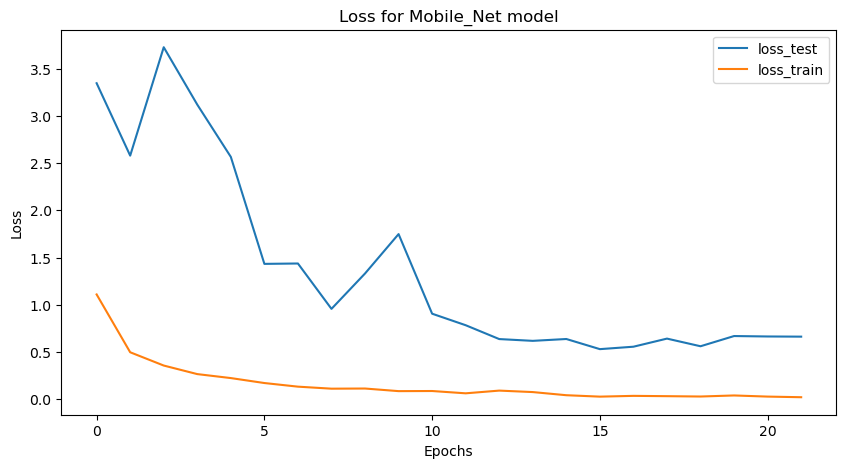

In [69]:
model=MobileNet()
accuracy_val_list,accuracy_train_list,loss_val_list,loss_train_list=training_test_model(train_loader,val_loader, test_loader,model,"MobileNet",epochs=50, learning_rate=0.001,weight_decay=1e-4,gamma=0.9,early_stopping_patience=5,early_stopping_save=True)
plot_train_loss(accuracy_val_list,accuracy_train_list,loss_val_list,loss_train_list,"Mobile_Net")


In [114]:
# Créer les jeux de données et les chargeurs de données
t_dataset = CustomDataset(X_test_full, y_test_full, test_transform)
t_loader = DataLoader(t_dataset, batch_size=10, shuffle=False)

In [115]:
class Feature_Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.mobilenet = mobilenet_v3_small(weights='IMAGENET1K_V1')
        self.mobilenet.classifier = nn.Identity()

    def forward(self, x):
        return self.mobilenet(x)
        


In [116]:
pretrained_model =rf"models_tg/MobileNet_88.pth"
model = Feature_Extractor()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(pretrained_model, map_location=device), strict=False)
model.to(device)
model.eval()
df=pd.DataFrame()

for i, (x, y) in enumerate(t_loader):
    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
        output = model(x)
        df=pd.concat([df,pd.DataFrame(output.cpu().numpy())])
        print(df.shape)

(10, 576)
(20, 576)
(30, 576)
(40, 576)
(50, 576)
(60, 576)
(70, 576)
(80, 576)
(90, 576)
(100, 576)
(110, 576)
(120, 576)
(130, 576)
(140, 576)
(150, 576)
(160, 576)
(170, 576)
(180, 576)
(190, 576)
(200, 576)
(210, 576)
(220, 576)
(230, 576)
(240, 576)
(250, 576)
(260, 576)
(270, 576)
(280, 576)
(290, 576)
(300, 576)
(310, 576)
(320, 576)
(330, 576)
(340, 576)
(350, 576)
(360, 576)
(370, 576)
(380, 576)
(390, 576)
(400, 576)
(410, 576)
(420, 576)
(430, 576)
(440, 576)
(450, 576)
(460, 576)
(470, 576)
(480, 576)
(490, 576)
(500, 576)
(506, 576)


In [127]:
au_df = pd.read_csv("../AU_models/dataset/partial_database.csv")

In [131]:
au_df["filename"] = X_full

In [135]:
au_test = au_df[au_df["filename"].isin(X_test_full)]

In [136]:
au_test

,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,filename
8,0.09,0.00,0.55,0.00,0.00,0.00,0.00,0.23,0.00,0.00,0.26,0.49,0.00,0.00,0.00,0.26,0.39,Image/neutral/01_009.jpg
12,0.73,0.49,0.25,0.00,0.36,0.00,0.00,0.22,0.47,0.21,0.00,0.44,0.18,0.55,0.20,0.61,0.18,Image/neutral/01_013.jpg
23,0.00,0.00,0.73,0.00,0.46,0.04,0.00,0.40,0.39,1.08,0.63,0.56,0.43,0.73,0.01,0.35,0.37,Image/neutral/01_024.jpg
26,0.00,0.02,0.66,0.00,0.15,0.04,0.54,0.05,0.08,0.12,0.80,1.46,0.34,0.29,0.00,0.18,0.08,Image/neutral/01_027.jpg
29,0.52,0.22,0.34,0.04,0.12,0.05,0.00,0.36,0.23,0.02,0.72,1.71,0.39,0.55,0.00,0.85,0.40,Image/neutral/01_030.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978,0.80,0.41,0.27,0.24,0.00,0.14,0.00,0.29,0.00,0.00,0.16,0.47,0.00,0.00,1.99,2.80,0.22,Image/Awed/22_149.jpg
5002,1.22,0.35,0.90,0.00,0.71,1.10,0.00,0.83,0.93,0.14,0.13,1.29,0.02,0.00,1.18,2.96,0.00,Image/Awed/22_173.jpg
5026,1.10,0.87,0.79,0.69,0.00,0.36,0.00,0.65,0.19,0.00,0.45,1.13,0.06,0.09,2.13,2.89,0.21,Image/Awed/22_197.jpg
5048,1.80,0.47,0.60,0.78,0.08,0.70,0.00,0.47,0.41,0.00,0.16,0.94,0.00,0.00,1.89,2.52,0.00,Image/Awed/22_219.jpg


In [137]:
df

,0,1,2,3,4,5,6,7,8,9,...,566,567,568,569,570,571,572,573,574,575
0,0.296105,0.491917,1.017336,0.038660,0.782699,0.318266,0.655325,0.937156,0.307206,0.222212,...,0.190083,0.190133,0.188924,0.404477,0.639926,0.772853,0.222845,0.149794,0.094883,-0.074156
1,0.372549,-0.223970,-0.214214,0.590657,0.685903,0.397092,1.554108,0.492586,0.102385,-0.112660,...,-0.021888,-0.204899,0.135100,1.151574,0.022930,1.026442,-0.044748,0.030253,0.265468,0.351452
2,0.368130,0.190689,0.989962,0.086350,0.724702,0.347256,0.416901,0.403468,0.083517,0.706257,...,0.125957,-0.048460,0.161734,0.575226,0.465520,-0.017434,0.072976,0.711666,0.128095,-0.039858
3,0.459799,0.080641,0.176306,0.473327,0.087260,0.483808,0.181613,0.227034,0.861669,-0.111733,...,1.143454,0.669014,0.998945,0.009127,0.356825,-0.156882,0.449426,0.685110,0.258853,-0.078747
4,0.687890,0.253551,1.582253,-0.006660,0.919078,0.901663,0.257715,0.739861,0.226957,0.963657,...,0.133991,0.566608,0.240382,0.578626,0.859630,0.364643,-0.137230,0.799791,0.292136,-0.164194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.301494,0.504506,-0.157817,0.640859,0.064805,0.262169,0.619396,0.295381,0.300928,0.597042,...,0.365986,-0.091253,1.193101,0.158918,0.218488,0.111179,1.170864,0.021165,0.213411,0.245635
2,0.463454,0.499345,-0.160016,-0.015046,-0.054237,0.422948,0.276226,0.013242,1.140800,0.545551,...,0.624549,0.826386,1.128712,-0.053121,0.139199,0.079066,0.762737,0.565546,-0.008224,-0.083190
3,-0.159608,0.779548,0.965291,0.594863,0.664449,0.519327,0.281538,0.133355,0.786948,-0.018260,...,-0.098489,0.243071,-0.090838,0.365060,0.578444,-0.086677,0.308268,0.083896,0.484199,0.827001
4,0.712951,0.385979,0.088335,-0.041925,0.060440,1.321188,0.011487,0.098310,0.698674,0.855466,...,0.270109,0.277489,0.690173,0.397199,0.294358,0.565407,0.030327,0.738168,0.046604,-0.108994


In [138]:
df

,0,1,2,3,4,5,6,7,8,9,...,566,567,568,569,570,571,572,573,574,575
0,0.296105,0.491917,1.017336,0.038660,0.782699,0.318266,0.655325,0.937156,0.307206,0.222212,...,0.190083,0.190133,0.188924,0.404477,0.639926,0.772853,0.222845,0.149794,0.094883,-0.074156
1,0.372549,-0.223970,-0.214214,0.590657,0.685903,0.397092,1.554108,0.492586,0.102385,-0.112660,...,-0.021888,-0.204899,0.135100,1.151574,0.022930,1.026442,-0.044748,0.030253,0.265468,0.351452
2,0.368130,0.190689,0.989962,0.086350,0.724702,0.347256,0.416901,0.403468,0.083517,0.706257,...,0.125957,-0.048460,0.161734,0.575226,0.465520,-0.017434,0.072976,0.711666,0.128095,-0.039858
3,0.459799,0.080641,0.176306,0.473327,0.087260,0.483808,0.181613,0.227034,0.861669,-0.111733,...,1.143454,0.669014,0.998945,0.009127,0.356825,-0.156882,0.449426,0.685110,0.258853,-0.078747
4,0.687890,0.253551,1.582253,-0.006660,0.919078,0.901663,0.257715,0.739861,0.226957,0.963657,...,0.133991,0.566608,0.240382,0.578626,0.859630,0.364643,-0.137230,0.799791,0.292136,-0.164194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.301494,0.504506,-0.157817,0.640859,0.064805,0.262169,0.619396,0.295381,0.300928,0.597042,...,0.365986,-0.091253,1.193101,0.158918,0.218488,0.111179,1.170864,0.021165,0.213411,0.245635
2,0.463454,0.499345,-0.160016,-0.015046,-0.054237,0.422948,0.276226,0.013242,1.140800,0.545551,...,0.624549,0.826386,1.128712,-0.053121,0.139199,0.079066,0.762737,0.565546,-0.008224,-0.083190
3,-0.159608,0.779548,0.965291,0.594863,0.664449,0.519327,0.281538,0.133355,0.786948,-0.018260,...,-0.098489,0.243071,-0.090838,0.365060,0.578444,-0.086677,0.308268,0.083896,0.484199,0.827001
4,0.712951,0.385979,0.088335,-0.041925,0.060440,1.321188,0.011487,0.098310,0.698674,0.855466,...,0.270109,0.277489,0.690173,0.397199,0.294358,0.565407,0.030327,0.738168,0.046604,-0.108994


In [141]:
au_df

,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,filename
0,0.00,0.00,0.28,0.00,0.31,1.19,0.0,0.26,0.10,0.00,0.71,0.89,0.00,0.00,0.00,0.82,0.00,Image/neutral/01_001.jpg
1,0.73,0.22,0.55,0.00,0.36,0.68,0.0,0.89,0.39,0.05,0.46,1.47,0.00,0.00,0.56,1.04,0.17,Image/neutral/01_002.jpg
2,0.66,0.22,1.48,0.00,0.45,0.44,0.0,0.81,0.36,0.07,0.22,2.36,0.11,0.51,0.56,1.25,0.87,Image/neutral/01_003.jpg
3,0.25,0.00,1.52,0.00,0.35,0.24,0.0,0.33,0.19,0.07,0.60,2.14,0.11,0.51,0.42,0.84,0.87,Image/neutral/01_004.jpg
4,0.00,0.00,1.71,0.00,0.24,0.31,0.0,0.36,0.25,0.02,0.38,1.89,0.11,0.51,0.05,0.58,0.69,Image/neutral/01_005.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5055,1.49,1.12,1.18,0.69,0.00,0.26,0.0,0.34,0.10,0.05,0.00,0.23,0.05,0.33,1.52,2.55,0.14,Image/Awed/22_226.jpg
5056,1.47,0.00,1.05,0.20,0.09,0.38,0.0,0.84,0.49,0.05,0.34,0.23,0.13,0.33,1.87,1.92,0.00,Image/Awed/22_227.jpg
5057,1.06,0.00,1.01,0.71,0.09,0.38,0.0,0.92,0.49,0.05,0.34,0.43,0.08,0.10,2.21,1.64,0.00,Image/Awed/22_228.jpg
5058,2.01,1.07,0.56,0.51,0.14,0.38,0.0,0.62,0.51,0.00,0.34,0.34,0.19,0.05,2.39,1.01,0.05,Image/Awed/22_229.jpg


In [144]:
df

,0,1,2,3,4,5,6,7,8,9,...,566,567,568,569,570,571,572,573,574,575
0,0.272610,0.396922,0.521581,0.151552,0.583330,0.285435,0.424819,0.538002,0.203859,0.251138,...,0.248892,0.208158,0.178928,0.183531,0.436980,0.368112,0.216788,0.155551,0.246448,0.074858
1,0.309027,0.000000,0.007574,0.488893,0.526763,0.328792,0.856951,0.308638,0.124929,0.071293,...,0.109610,0.000000,0.157228,0.455023,0.098513,0.458584,0.076196,0.084268,0.382739,0.253918
2,0.306921,0.229907,0.510156,0.180697,0.549437,0.301380,0.310185,0.262660,0.117659,0.511097,...,0.206756,0.082434,0.167966,0.245580,0.341306,0.086164,0.138047,0.490601,0.272984,0.089288
3,0.350590,0.168891,0.170564,0.417189,0.176921,0.376490,0.197059,0.171633,0.417526,0.071791,...,0.875331,0.460500,0.505505,0.039862,0.281678,0.036413,0.335833,0.474766,0.377454,0.072927
4,0.459248,0.264761,0.757357,0.123855,0.663029,0.606328,0.233649,0.436213,0.172935,0.649336,...,0.212035,0.406538,0.199675,0.246816,0.557503,0.222476,0.027606,0.543152,0.404046,0.036978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.275178,0.403902,0.031112,0.519573,0.163798,0.254579,0.407544,0.206895,0.201440,0.452443,...,0.364473,0.059885,0.583783,0.094296,0.205791,0.132049,0.714874,0.078849,0.341148,0.209399
502,0.352331,0.401040,0.030194,0.118731,0.094231,0.343015,0.242549,0.061332,0.525092,0.424789,...,0.534370,0.543426,0.557824,0.017242,0.162295,0.120592,0.500445,0.403469,0.164070,0.071058
503,0.055519,0.556399,0.499859,0.491463,0.514225,0.396027,0.245103,0.123302,0.388732,0.121991,...,0.059277,0.236054,0.066136,0.169207,0.403252,0.061460,0.261669,0.116256,0.557495,0.453988
504,0.471186,0.338185,0.133847,0.102304,0.161247,0.837086,0.115263,0.105221,0.354715,0.591231,...,0.301475,0.254190,0.381017,0.180886,0.247411,0.294102,0.115640,0.506405,0.207876,0.060201


In [150]:
au_test.reset_index(drop=True, inplace=True)

In [164]:
df.reset_index(inplace=True, drop=True)
dataset = df
#normalize data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler((0,1))

# scaler = StandardScaler()

dataset.iloc[:,:] = scaler.fit_transform(dataset.iloc[:,:])
dataset = pd.concat([dataset,au_test],axis=1)
dataset.reset_index(inplace=True, drop=True)
dataset["labels"]=[int(x.split("/")[-1].split("_")[0]) for x in dataset["filename"]]
dataset["filename"]=X_test_full

In [165]:
au_test

,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,filename
0,0.09,0.00,0.55,0.00,0.00,0.00,0.00,0.23,0.00,0.00,0.26,0.49,0.00,0.00,0.00,0.26,0.39,Image/neutral/01_009.jpg
1,0.73,0.49,0.25,0.00,0.36,0.00,0.00,0.22,0.47,0.21,0.00,0.44,0.18,0.55,0.20,0.61,0.18,Image/neutral/01_013.jpg
2,0.00,0.00,0.73,0.00,0.46,0.04,0.00,0.40,0.39,1.08,0.63,0.56,0.43,0.73,0.01,0.35,0.37,Image/neutral/01_024.jpg
3,0.00,0.02,0.66,0.00,0.15,0.04,0.54,0.05,0.08,0.12,0.80,1.46,0.34,0.29,0.00,0.18,0.08,Image/neutral/01_027.jpg
4,0.52,0.22,0.34,0.04,0.12,0.05,0.00,0.36,0.23,0.02,0.72,1.71,0.39,0.55,0.00,0.85,0.40,Image/neutral/01_030.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.80,0.41,0.27,0.24,0.00,0.14,0.00,0.29,0.00,0.00,0.16,0.47,0.00,0.00,1.99,2.80,0.22,Image/Awed/22_149.jpg
502,1.22,0.35,0.90,0.00,0.71,1.10,0.00,0.83,0.93,0.14,0.13,1.29,0.02,0.00,1.18,2.96,0.00,Image/Awed/22_173.jpg
503,1.10,0.87,0.79,0.69,0.00,0.36,0.00,0.65,0.19,0.00,0.45,1.13,0.06,0.09,2.13,2.89,0.21,Image/Awed/22_197.jpg
504,1.80,0.47,0.60,0.78,0.08,0.70,0.00,0.47,0.41,0.00,0.16,0.94,0.00,0.00,1.89,2.52,0.00,Image/Awed/22_219.jpg


In [167]:
dataset.to_csv("testing_database",index=False)

In [ ]:
df["label"] = y_test
df ["filename"] = X_test